In [13]:
from transformers import AutoImageProcessor, ViTForImageClassification
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [14]:
model_name = "google/vit-base-patch16-224"

image_processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)
model = ViTForImageClassification.from_pretrained(model_name, output_attentions=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

cuda


In [ ]:
img_paths = [
    "img/bicycle-built-for-two.jpg",
    "img/rubber_eraser.jpg",
    "img/seat_belt.jpg",
    "img/space_shuttle.jpg",
    "img/vacuum.jpg"
]

images = [Image.open(path).convert("RGB") for path in img_paths]
inputs = image_processor(images=images, return_tensors="pt")

In [16]:
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions
    logits = outputs.logits

predicted_ids = logits.argmax(dim=1).tolist()
labels = model.config.id2label
for i, pred in enumerate(predicted_ids):
    print(f"Image {i+1}: {labels[pred]}")

Image 1: bicycle-built-for-two, tandem bicycle, tandem
Image 2: rubber eraser, rubber, pencil eraser
Image 3: seat belt, seatbelt
Image 4: space shuttle
Image 5: vacuum, vacuum cleaner


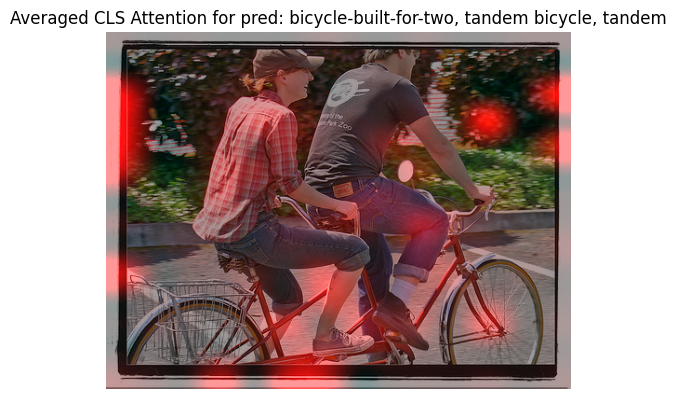

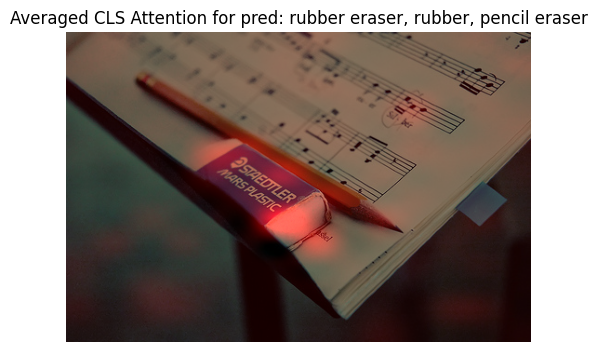

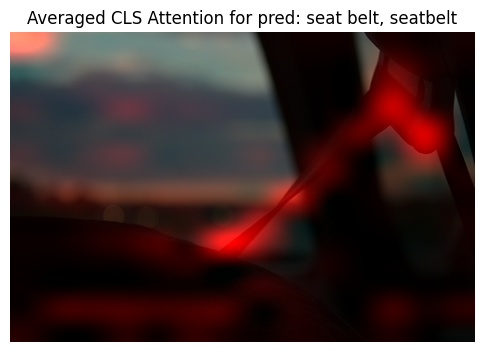

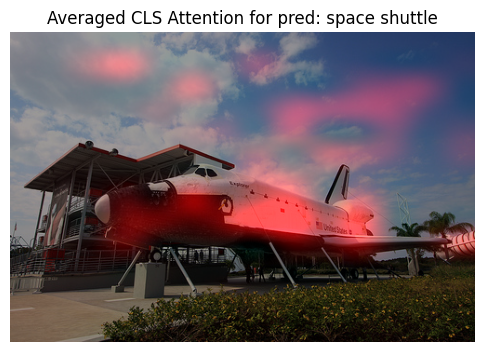

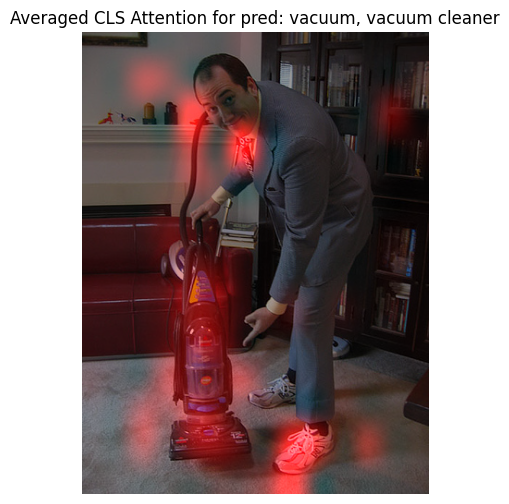

In [ ]:
for idx, img in enumerate(images):
    cls_attn = attentions[-1][idx]
    cls_attn = cls_attn.mean(dim=0)
    cls_attn_vector = cls_attn[0, 1:]
    attn_map = cls_attn_vector.reshape(14, 14).cpu().numpy()
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())
    attn_map_resized = cv2.resize(attn_map, img.size, interpolation=cv2.INTER_CUBIC)
    img_np = np.array(img).astype(np.float32) / 255.0
    heatmap = np.zeros_like(img_np)
    heatmap[:, :, 0] = attn_map_resized

    overlay = 0.6 * img_np + heatmap
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Averaged CLS Attention for pred: {labels[predicted_ids[idx]]}")
    plt.show()